<a href="https://colab.research.google.com/github/AutoProvision/market-analysis.notebook/blob/main/analise_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
%pip install polars matplotlib requests numpy

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import zipfile, requests, os

In [ ]:
url = 'https://www.bcb.gov.br/pda/desig/planilha_2024.zip'

if not os.path.exists('planilha_2024.zip'):

	response = requests.get(url)

	with open('planilha_2024.zip', 'wb') as f:
		f.write(response.content)

In [ ]:
if not os.path.exists('pasta_extraida'):
	with zipfile.ZipFile('planilha_2024.zip', 'r') as zip_obj:
		zip_obj.extractall('pasta_extraida')
		print('Arquivo extraído com sucesso!')

In [ ]:
maio = pl.read_csv('pasta_extraida/planilha_202405.csv', separator=';', truncate_ragged_lines=True)
junho = pl.read_csv('pasta_extraida/planilha_202406.csv', separator=';', truncate_ragged_lines=True)
julho = pl.read_csv('pasta_extraida/planilha_202407.csv', separator=';', truncate_ragged_lines=True)

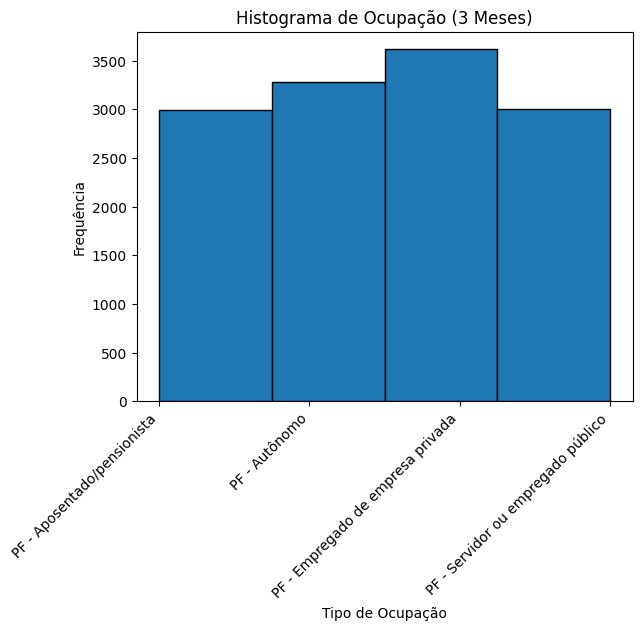

In [ ]:
dfs = [maio, junho, julho]
ocupacao_total = []

for df in dfs:
    df = df.with_columns(
        pl.col('ocupacao').str.strip_chars(" ").alias('ocupacao')
    )
    df_limpo = df.filter(
        (pl.col('ocupacao') != "PF - Outros") &
        (pl.col('uf') == "SP") &
         (pl.col('ocupacao') != "PF - MEI") &
        (pl.col('ocupacao') != "PF - Empregado de entidades sem fins lucrativos") &
        (pl.col('ocupacao') != "PF - Empresário") &
        (pl.col('ocupacao') != "-") &
        (pl.col('ocupacao').is_not_null())
    )
    ocupacao_total.extend(df_limpo['ocupacao'].to_list())

plt.hist(ocupacao_total, bins=len(set(ocupacao_total)), edgecolor='black')
plt.title('Histograma de Ocupação (3 Meses)')
plt.xlabel('Tipo de Ocupação')
plt.ylabel('Frequência')
plt.xticks(rotation=45, ha='right')
plt.show()

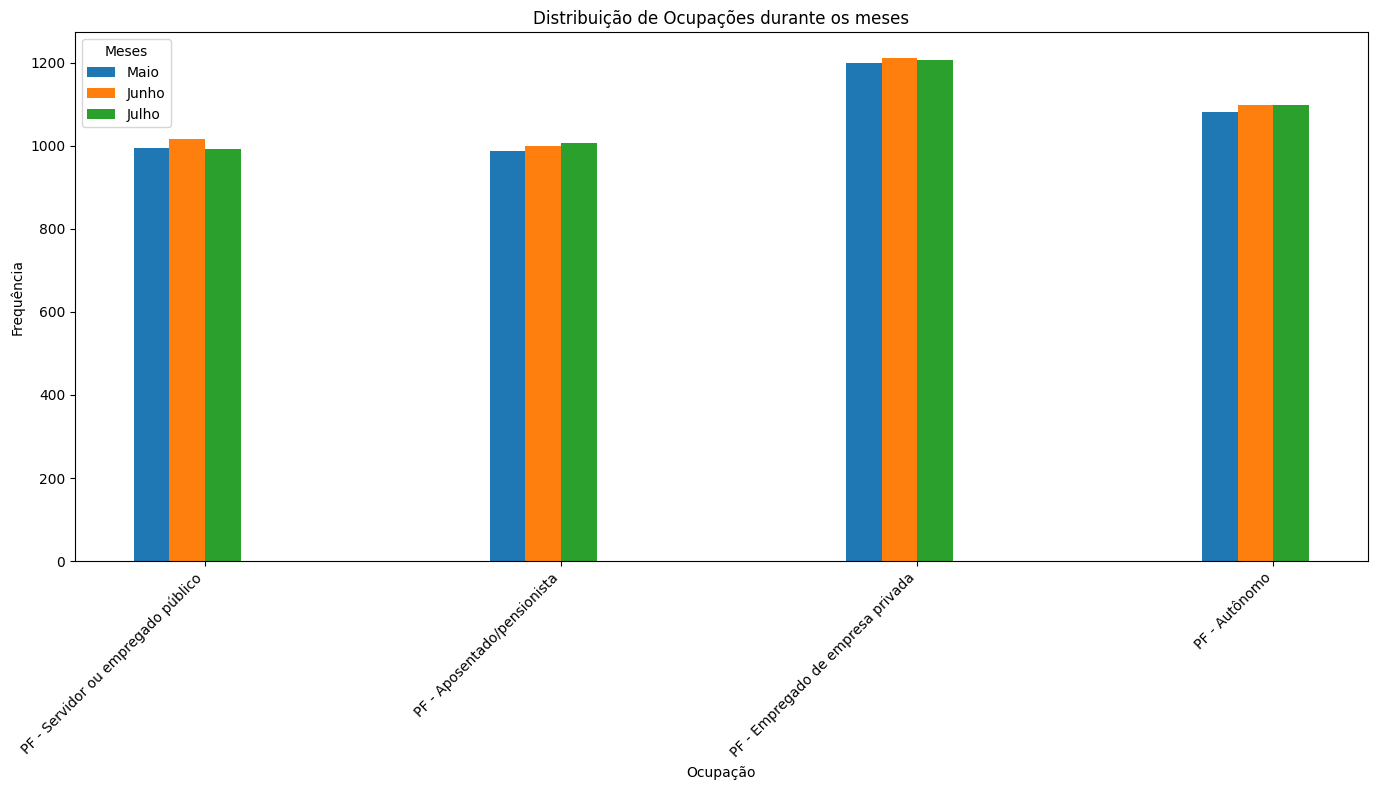

In [ ]:
dfs = [maio, junho, julho]
nomes_meses = ["Maio", "Junho", "Julho"]

ocupacoes = []
ocupacao_unica = set()

for df in dfs:
    df = df.with_columns(
        pl.col('ocupacao').str.strip_chars(" ").alias('ocupacao')
    )
    df_limpo = df.filter(
        (pl.col('ocupacao') != "PF - Outros") &
        (pl.col('ocupacao') != "PF - MEI") &
        (pl.col('ocupacao') != "PF - Empregado de entidades sem fins lucrativos") &
        (pl.col('ocupacao') != "PF - Empresário") &
        (pl.col('uf') == "SP") &
        (pl.col('ocupacao') != "-") &
        (pl.col('ocupacao').is_not_null())
    )
    contagem = df_limpo['ocupacao'].value_counts()
    ocupacoes.append(contagem)
    ocupacao_unica.update(contagem['ocupacao'].to_list())

ocupacao_unica = list(ocupacao_unica)

ind = np.arange(len(ocupacao_unica))
largura = 0.1

fig, ax = plt.subplots(figsize=(14, 8))

for i, df_contagem in enumerate(ocupacoes):
    valores = [df_contagem.filter(pl.col('ocupacao') == ocupacao).select(pl.col('count')).to_series().to_list()[0]
               if df_contagem.filter(pl.col('ocupacao') == ocupacao).height > 0 else 0
               for ocupacao in ocupacao_unica]
    ax.bar(ind + i * largura, valores, largura, label=nomes_meses[i])

ax.set_title('Distribuição de Ocupações durante os meses')
ax.set_xlabel('Ocupação')
ax.set_ylabel('Frequência')
ax.set_xticks(ind + largura * (len(dfs) / 2))
ax.set_xticklabels(ocupacao_unica, rotation=45, ha='right')
ax.legend(title='Meses')

plt.tight_layout()
plt.show()

In [ ]:
dfs = [maio, junho, julho]

combined_df = pl.concat(dfs)

In [ ]:
pessoa_fisica_df = combined_df.filter(pl.col('cliente') == 'PF')
pessoa_juridica_df = combined_df.filter(pl.col('cliente') == 'PJ')

In [ ]:
pessoa_fisica_df

data_base,uf,tcb,sr,cliente,ocupacao,cnae_secao,cnae_subclasse,porte,modalidade,origem,indexador,numero_de_operacoes,a_vencer_ate_90_dias,a_vencer_de_91_ate_360_dias,a_vencer_de_361_ate_1080_dias,a_vencer_de_1081_ate_1800_dias,a_vencer_de_1801_ate_5400_dias,a_vencer_acima_de_5400_dias,vencido_acima_de_15_dias,carteira_ativa,carteira_inadimplida_arrastada,ativo_problematico
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""2024-05-31""","""AC""","""Bancário""","""S1""","""PF""","""PF - Aposentado/pensionista""","""-""","""-""","""PF - Acima de 20 salários míni…","""PF - Cartão de crédito""","""Sem destinação específica""","""Prefixado""","""509""","""3283461,26""","""966152,50""","""140075,94""","""17894,74""","""47148,09""","""0,00""","""340315,96""","""4795048,49""","""281956,15""","""396522,02"""
"""2024-05-31""","""AC""","""Bancário""","""S1""","""PF""","""PF - Aposentado/pensionista""","""-""","""-""","""PF - Acima de 20 salários míni…","""PF - Empréstimo com consignaçã…","""Sem destinação específica""","""Prefixado""","""565""","""1217328,27""","""3921387,99""","""9380602,65""","""7549265,79""","""8040358,66""","""0,00""","""178913,65""","""30287857,01""","""1321453,57""","""1399949,87"""
"""2024-05-31""","""AC""","""Bancário""","""S1""","""PF""","""PF - Aposentado/pensionista""","""-""","""-""","""PF - Acima de 20 salários míni…","""PF - Empréstimo com consignaçã…","""Sem destinação específica""","""Pós-fixado""","""<= 15""","""0,00""","""0,00""","""0,00""","""0,00""","""0,00""","""0,00""","""45090,47""","""45090,47""","""45090,47""","""45090,47"""
"""2024-05-31""","""AC""","""Bancário""","""S1""","""PF""","""PF - Aposentado/pensionista""","""-""","""-""","""PF - Acima de 20 salários míni…","""PF - Empréstimo sem consignaçã…","""Sem destinação específica""","""Prefixado""","""169""","""397615,44""","""711632,07""","""1076611,37""","""464018,00""","""158225,60""","""0,00""","""3571,33""","""2811673,81""","""20369,97""","""43194,79"""
"""2024-05-31""","""AC""","""Bancário""","""S1""","""PF""","""PF - Aposentado/pensionista""","""-""","""-""","""PF - Acima de 20 salários míni…","""PF - Habitacional""","""Com destinação específica""","""Pós-fixado""","""<= 15""","""64027,23""","""178598,78""","""402626,61""","""292407,56""","""588230,66""","""78123,82""","""0,00""","""1604014,66""","""0,00""","""0,00"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2024-07-31""","""TO""","""Não bancário""","""S5""","""PF""","""PF - Servidor ou empregado púb…","""-""","""-""","""PF - Mais de 5 a 10 salários m…","""PF - Cartão de crédito""","""Sem destinação específica""","""Prefixado""","""465""","""167606,31""","""743390,97""","""23088,89""","""0,00""","""0,00""","""0,00""","""77751,59""","""1011837,76""","""56052,78""","""75933,07"""
"""2024-07-31""","""TO""","""Não bancário""","""S5""","""PF""","""PF - Servidor ou empregado púb…","""-""","""-""","""PF - Mais de 5 a 10 salários m…","""PF - Empréstimo sem consignaçã…","""Sem destinação específica""","""Prefixado""","""25""","""30589,26""","""47765,40""","""57824,10""","""22635,17""","""357,28""","""0,00""","""6724,54""","""165895,75""","""45863,51""","""58732,67"""
"""2024-07-31""","""TO""","""Não bancário""","""S5""","""PF""","""PF - Servidor ou empregado púb…","""-""","""-""","""PF - Mais de 5 a 10 salários m…","""PF - Outros créditos""","""Sem destinação específica""","""Prefixado""","""17""","""16834,58""","""19767,28""","""24413,79""","""12732,00""","""0,00""","""0,00""","""4981,04""","""78728,69""","""4081,06""","""4081,06"""


In [ ]:
combined_df  = df.with_columns(
    pl.col("carteira_inadimplida_arrastada").str.replace(",", ".").cast(pl.Float64)
)
combined_df  = combined_df.select(["uf","cliente","ocupacao", "carteira_inadimplida_arrastada"])

In [ ]:
combined_df

uf,cliente,ocupacao,carteira_inadimplida_arrastada
str,str,str,f64
"""AC""","""PF""","""PF - Aposentado/pensionista""",129021.18
"""AC""","""PF""","""PF - Aposentado/pensionista""",1.2287e6
"""AC""","""PF""","""PF - Aposentado/pensionista""",45090.47
"""AC""","""PF""","""PF - Aposentado/pensionista""",36282.35
"""AC""","""PF""","""PF - Aposentado/pensionista""",0.0
…,…,…,…
"""TO""","""PJ""","""-""",0.0
"""TO""","""PJ""","""-""",354.33
"""TO""","""PJ""","""-""",0.0


In [ ]:
df_tratado_pf = combined_df.filter(pl.col('cliente') == 'PF')
df_tratado_pj = combined_df.filter(pl.col('cliente') == 'PJ')

In [ ]:
df_tratado_pf

uf,cliente,ocupacao,carteira_inadimplida_arrastada
str,str,str,f64
"""AC""","""PF""","""PF - Aposentado/pensionista""",129021.18
"""AC""","""PF""","""PF - Aposentado/pensionista""",1.2287e6
"""AC""","""PF""","""PF - Aposentado/pensionista""",45090.47
"""AC""","""PF""","""PF - Aposentado/pensionista""",36282.35
"""AC""","""PF""","""PF - Aposentado/pensionista""",0.0
…,…,…,…
"""TO""","""PF""","""PF - Servidor ou empregado púb…",56052.78
"""TO""","""PF""","""PF - Servidor ou empregado púb…",45863.51
"""TO""","""PF""","""PF - Servidor ou empregado púb…",4081.06


In [ ]:
valor_especifico_modalidade = "PF - Empregado de empresa privada"
valor_especifico_uf = "SP"

df_filtrado = combined_df.filter(
    (pl.col("ocupacao") == valor_especifico_modalidade) &
    (pl.col("uf") == valor_especifico_uf)
)

media_valor = df_filtrado["carteira_inadimplida_arrastada"].mean()
print(f"A média do valor para '{valor_especifico_modalidade}'é: {media_valor}")


A média do valor para 'PF - Empregado de empresa privada'é: 7677546.482120961


In [ ]:
valor_especifico_modalidade = "PF - Aposentado/pensionista"
valor_especifico_uf = "SP"

df_filtrado = combined_df.filter(
    (pl.col("ocupacao") == valor_especifico_modalidade) &
    (pl.col("uf") == valor_especifico_uf)
)

media_valor1 = df_filtrado["carteira_inadimplida_arrastada"].mean()
print(f"A média do valor para '{valor_especifico_modalidade}'é: {media_valor1}")

A média do valor para 'PF - Aposentado/pensionista'é: 1900781.3521747764


In [ ]:
valor_especifico_modalidade = "PF - Autônomo"
valor_especifico_uf = "SP"

df_filtrado = combined_df.filter(
    (pl.col("ocupacao") == valor_especifico_modalidade) &
    (pl.col("uf") == valor_especifico_uf)
)

media_valor2 = df_filtrado["carteira_inadimplida_arrastada"].mean()
print(f"A média do valor para '{valor_especifico_modalidade}'é: {media_valor2}")

A média do valor para 'PF - Autônomo'é: 1650807.1410564661


In [ ]:
valor_especifico_modalidade = "PF - Servidor ou empregado público"
valor_especifico_uf = "SP"

df_filtrado = combined_df.filter(
    (pl.col("ocupacao") == valor_especifico_modalidade) &
    (pl.col("uf") == valor_especifico_uf)
)

media_valor3 = df_filtrado["carteira_inadimplida_arrastada"].mean()
print(f"A média do valor para '{valor_especifico_modalidade}'é: {media_valor3}")

A média do valor para 'PF - Servidor ou empregado público'é: 2731276.445383064


In [ ]:
formatted_valores = [f"{valor:.2f}" if valor is not None else "0.00" for valor in [media_valor,media_valor1, media_valor2, media_valor3]]

df_resultado = pl.DataFrame({
    "Categoria": ["PF - Empregado de empresa privada", "PF - Aposentado/pensionista", "PF - Autônomo", "PF - Servidor ou empregado público"],
    "media_valor": formatted_valores
})
df_resultado = df_resultado.with_columns(
    pl.col("media_valor").str.replace(",", ".").cast(pl.Float64)
)
print(df_resultado)

shape: (4, 2)
┌─────────────────────────────────┬─────────────┐
│ Categoria                       ┆ media_valor │
│ ---                             ┆ ---         │
│ str                             ┆ f64         │
╞═════════════════════════════════╪═════════════╡
│ PF - Empregado de empresa priv… ┆ 7.6775e6    │
│ PF - Aposentado/pensionista     ┆ 1.9008e6    │
│ PF - Autônomo                   ┆ 1.6508e6    │
│ PF - Servidor ou empregado púb… ┆ 2.7313e6    │
└─────────────────────────────────┴─────────────┘


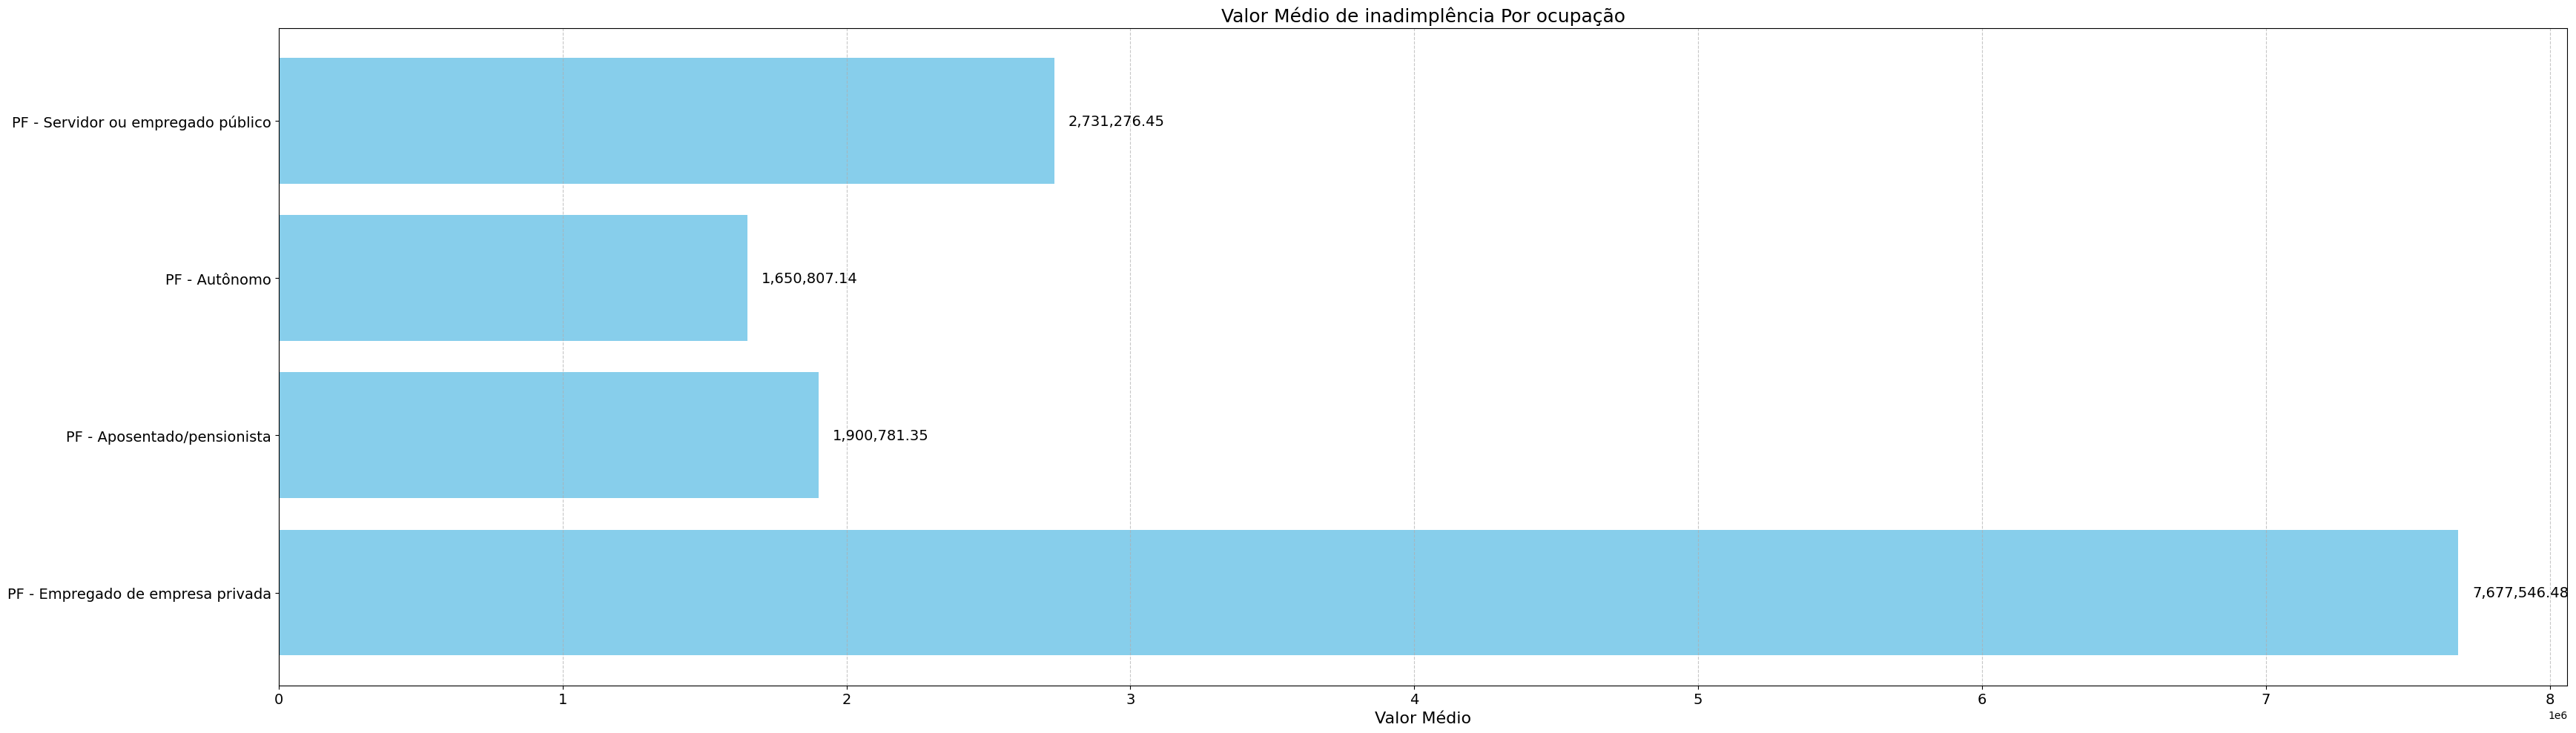

In [ ]:
categorias = df_resultado["Categoria"].to_numpy().tolist()
valores = df_resultado["media_valor"].to_numpy().tolist()

valores_formatados = [f"{v:,.2f}" for v in valores]

plt.figure(figsize=(35, 10))
bars = plt.barh(categorias, valores, color='skyblue')

for bar, valor in zip(bars, valores_formatados):
    plt.text(
        bar.get_width() + 50000,
        bar.get_y() + bar.get_height()/2,
        valor,
        va='center',
        ha='left',
        fontsize=14
    )

plt.xlabel('Valor Médio', fontsize=16)
plt.title('Valor Médio de inadimplência Por ocupação', fontsize=18)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.yticks(fontsize=14)

plt.xticks(fontsize=14)

plt.tight_layout()
plt.show()